# Computing and visualization of linear trends during the observed period (1980-2014) for precipitation

The code and figures presented herein reproduces the figures () of Section () of the 6th Intergovermental Panel on Climate Change (IPCC). These figures depict the observed linear trends and the anomalies time series of precipitation world-wide (indications for temperature are also available), over a selected time period. Though this is to be done for various observational datasets (), to account for the observational uncertainty, and for two target variables (precipitation and temperature), for the sake of we illustrate the generation of the figures for only the CRU-TS dataset over North America, for precipitation. However, during the notebook we indicate which parts are to be tuned to elaborate the same figures for other observational datasets.

We build on the climate4R framework, a set of R libraries especifically developed for the tasks of loading, processing and manipulation of climate data. For more information regarding this framework and its installation, we refer the reader to the GitHub repository that provides all the information necessary.

In [21]:
library(loadeR) # C4R
library(transformeR) # C4R
library(visualizeR) # C4R
library(geoprocessoR) # C4R
library(climate4R.value) # C4R
library(climate4R.indices) # C4R

library(magrittr) # The package magrittr is used to pipe (%>%) sequences of data operations improving readability
library(gridExtra) # plotting functionalities
library(sp) # plotting functionalities
library(RColorBrewer)  # plotting functionalities e.g., color palettes
library(rgdal)

We use the function `loadGridData` of library `loadeR` to build a land-sea mask at 0.25º of spatial resolution, by relying on the ERA5 grid. Once loaded, we call `binaryGrid` of `transformeR` to build the mask. Note that we only load the North America domain, by inputting the appropiate latitude and longitude coordinates on the `latLim` and `lonLim` arguments, respectively. We point to the ERA5 netCDF file that stores the data, located in this [GitHub repository](https://raw.githubusercontent.com/SantanderMetGroup/ATLAS/master/), an call it via the `dataset` argument.

In [9]:
# download the .nc from this route https://raw.githubusercontent.com/SantanderMetGroup/ATLAS/master/reference-grids/land_sea_mask_025degree_ERA5.nc
# point to the .nc in your local directory in the `dataset` argument
mask <- loadGridData(dataset = "../reference-grids/land_sea_mask_025degree_ERA5.nc", 
                     var = "lsm",
                     latLim = c(12,74),
                     lonLim = c(-170,-50)) %>% binaryGrid(condition = "GE", threshold = 0.001, values = c(NA,1))

We load the IPCC regions (see [reference paper](https://essd.copernicus.org/articles/12/2959/2020/essd-12-2959-2020.html)), that can be found as an `.rda` file in the [ATLAS GitHub reository](https://github.com/SantanderMetGroup/ATLAS/tree/master/reference-regions).

In [15]:
# We load the coast, to be used in the below spatial maps. Note that all the WORLD_coastline files located in 
# https://github.com/SantanderMetGroup/ATLAS/tree/master/man
# have to be downloaded to your working directory
coast <- readOGR("../man/WORLD_coastline.shp") 
# We use the `url` function to access the data directly from the ATLAS GitHub repository
regs <- get(load(url("https://raw.githubusercontent.com/SantanderMetGroup/ATLAS/master/reference-regions/IPCC-WGI-reference-regions-v4_R.rda")))
regs <- as(regs, "SpatialPolygons")
regs.area <- c("NWN", "NEN", "WNA", "CNA","ENA","NCA","SCA","CAR") # North America regions

### Load data from the UDG

We load the data hosted in the [User Data Gateway (UDG)](http://meteo.unican.es/udg-tap/home), which is a THREDDS-based service from the Santander Climate Data Service (CDS) that enables the access to the data to load it into our session (register [here](http://meteo.unican.es/udg-tap/signup) freely to get a user). Once we have obtained our credentials we can log in using the `loginUDG` function from `loadeR`:

In [12]:
loginUDG(username = "***", password = "***") # log into the Santander CDS
# UDG.datasets(pattern = "CRU") # Uncomment this line to look for other datasets stored in the UDG

We call `loadGridData` to load the CRU dataset into the R session by using the label associated to this dataset (see `UDG.datasets()`). We build a loop over the time period (1980-2014) for computational concerns, and we 1) aggregate the daily data into a yearly time series by calling `aggregateGrid`, 2) intersect the CRU-TS spatial resolution to the ERA5 resolution by calling `intersectGrid` and 3) multiplying the object with the mask built previously with `gridArithmetics`. All these 3 functions belong to the `C4R` library `transformeR`.

In [ ]:
grid <- lapply(1980:2014, FUN = function(zz){
    aux <- loadGridData(dataset = "CRU-TS",
                        var = "pr", # replace "pr" for "tas" to download surface temperature. Type C4R.vocabulary() for more information regarding the code of the variables
                        latLim = c(12,74),
                        lonLim = c(-170,-50),
                        years = zz) %>% aggregateGrid(aggr.y = list(FUN = "sum", na.rm = TRUE)) %>% interpGrid(new.coordinates = list("x" = mask$xyCoords$x,"y" = mask$xyCoords$y)) %>% gridArithmetics(mask)
}) %>% bindGrid(dimension = "time")                                         
attr(grid$xyCoords, "projection") <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"  

### Load data stored in the Atlas hub
To load data stored in the Atlas hub (similar to loading data from a local directory), we rely on the C4R library called `climate4R.hub`, that contains 2 main functions: `HUB.datasets` and `loadHubData`.

*** NOTE: We should be working on the Atlas hub for these chunks of code to work. ***

On the one hand, `HUB.datasets` lists all the datasets accessible from the Atlas Hub.

In [ ]:
# devtools::install_github("SantanderMetGroup/climate4R.hub") # Uncomment this line to install climate4R.hub
library(climate4R.hub)
HUB.datasets()

We see how, to-date, only Daymet and E-OBS datasets are available from the Atlas Hub (more coming). For example, to load Daymet we just input the Daymet label to the `dataset` argument in `loadHubData` (which contains the same arguments than `loadGridData`)

In [ ]:
grid <- lapply(1980:2014, FUN = function(zz){
    aux <- loadHubData(dataset = "Daymet_v3_0.25regular",
                        var = "pr", # replace "pr" for "tas" to download surface temperature. Type C4R.vocabulary() for more information regarding the code of the variables
                        latLim = c(12,74),
                        lonLim = c(-170,-50),
                        years = zz) %>% aggregateGrid(aggr.y = list(FUN = "sum", na.rm = TRUE)) %>% gridArithmetics(mask)
}) %>% bindGrid(dimension = "time")                                         
attr(grid$xyCoords, "projection") <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"  

### Working with loaded data

We define the geographical projection.

In [ ]:
proj4string(regs) <- CRS(attr(grid$xyCoords,"projection"))

We compute the climatology by calling the `climatology` function and then use `spatialPlot` from library `visualizeR` to depict it. We introduce the IPCC regions of interest in the `sp.layout` argument.

[2020-11-25 16:54:47] - Computing climatology...

[2020-11-25 16:54:48] - Done.

Warning message in SpatialPointsDataFrame(spp, data.frame(Lines.NR = L3, Lines.ID = L2, :
“If the coords argument is a SpatialPoints object, set its CRS first;
  the proj4string argument to this function is ignored.”
Warning message in SpatialPointsDataFrame(spp, data.frame(Lines.NR = L3, Lines.ID = L2, :
“If the coords argument is a SpatialPoints object, set its CRS first;
  the proj4string argument to this function is ignored.”


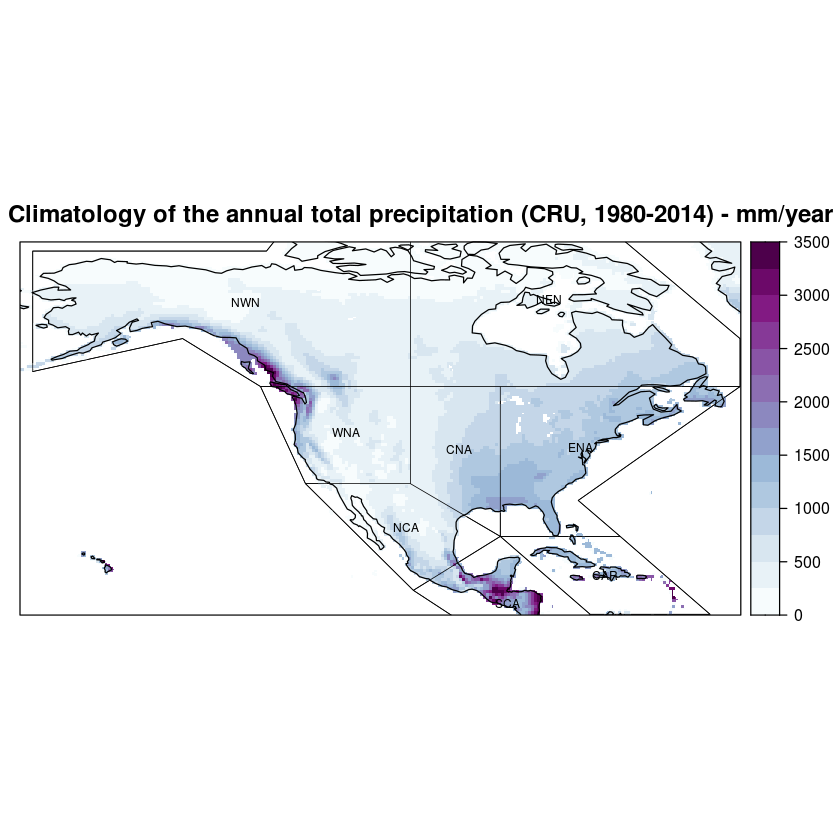

In [17]:
# pdf("climatology.pdf") ## Uncomment to save the figure
spatialPlot(climatology(grid),
            at = seq(0, 3500, 250), 
            set.min = 0,
            set.max = 3500,
            backdrop.theme = "coastline",
            col.regions = brewer.pal(n = 9, "BuPu") %>% colorRampPalette(),
            main = paste("Climatology of the annual total precipitation (CRU, 1980-2014) - mm/year"),
            sp.layout = list(
                list(regs[regs.area], first = FALSE, lwd = 0.6),
                list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
)) 
# dev.off() ## Uncomment to save the figure

We call the function `linearTrend` that computes the linear points at gridbox level and returns all the involved statistics (e.g., p-value of the estimated slope). We subset the slope ("b") and the p-value ("pval") among all the statistics returned, by calling `subsectGrid`. 

In [ ]:
trendGrid <- linearTrend(grid, p = 0.9) %>% subsetGrid(var = "b")
pvalGrid <- linearTrend(grid, p = 0.9) %>% subsetGrid(var = "pval") %>% gridArithmetics(mask) %>% overGrid(regs[regs.area])
# library(loadeR.2nc) # uncomment to save the trends as netCDF files
# grid2nc(trendGrid, NetCDFOutFile = "trends.nc4") # uncomment to save the trends as netCDF files

We call the function `overGrid` that overlaps the trends object with the IPCC regions located over NorthAmerica.

In [23]:
regsGrid <- overGrid(trendGrid, regs[regs.area])

We use the p-values computed above to perform hatching over the future spatial maps. To do so, we capsulate the function `map.hatching` in a 2-way loop that corresponds to each line in a 'x' symbol. An 'x' would be associated whenever the condition is fullfilled, in our casem whenever the p-value is greater than 0.1. The `aggr.fun` indicates how to treat/aggregate the information contained in adjacent spatial gridpoints when upscaling is done.

In [ ]:
aggr.fun <- function(x) {
    xx <- length(which(!is.na(x)))/length(x) * 100
    if (as.numeric(xx >= 75)) 0 else NA
}
l <- lapply(c("45","-45"), FUN = function(z) {
    c(map.hatching(clim = climatology(pvalGrid), 
                   threshold = 0.1, 
                   condition = "GT", 
                   density = 6,
                   angle = z, coverage.percent = 50,
                   upscaling.aggr.fun = list(FUN = aggr.fun)), 
    "which" = 1, lwd = 0.6)
})

We rely on `spatialPlot` from visualizeR, to depict the trend maps and include the p-value as hatching as a member of the `sp.layout` list.

Warning message in SpatialPointsDataFrame(spp, data.frame(Lines.NR = L3, Lines.ID = L2, :
“If the coords argument is a SpatialPoints object, set its CRS first;
  the proj4string argument to this function is ignored.”
Warning message in SpatialPointsDataFrame(spp, data.frame(Lines.NR = L3, Lines.ID = L2, :
“If the coords argument is a SpatialPoints object, set its CRS first;
  the proj4string argument to this function is ignored.”
Warning message in SpatialPointsDataFrame(spp, data.frame(Lines.NR = L3, Lines.ID = L2, :
“If the coords argument is a SpatialPoints object, set its CRS first;
  the proj4string argument to this function is ignored.”
Warning message in SpatialPointsDataFrame(spp, data.frame(Lines.NR = L3, Lines.ID = L2, :
“If the coords argument is a SpatialPoints object, set its CRS first;
  the proj4string argument to this function is ignored.”


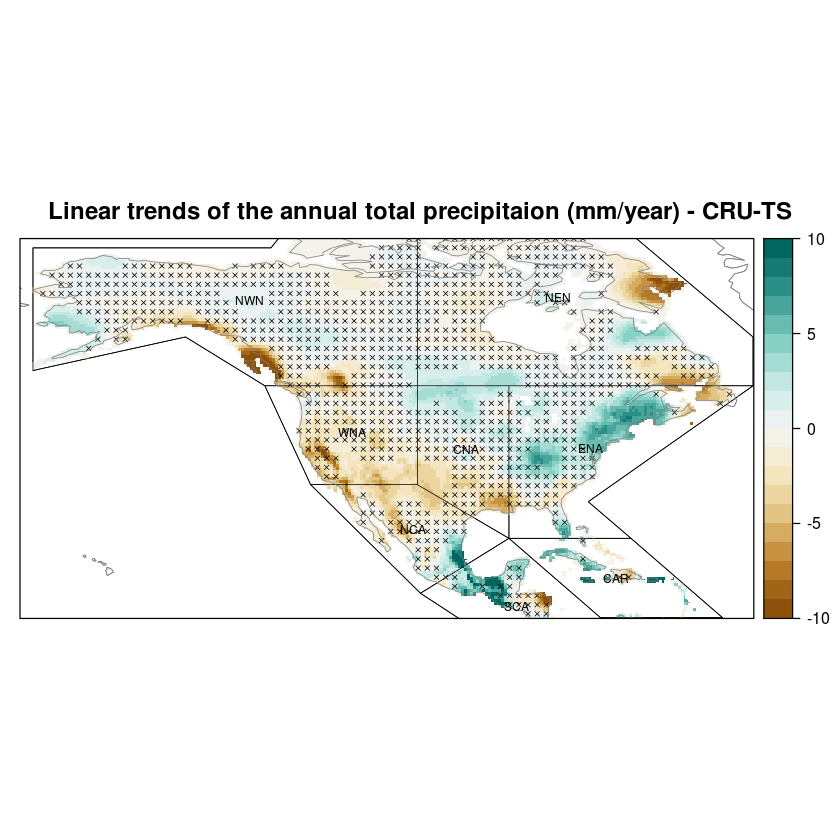

In [25]:
spatialPlot(regsGrid, 
            col.regions = brewer.pal(n = 9, "BrBG") %>% colorRampPalette(),
            at = seq(-10, 10, 1), 
            set.min = -10,
            set.max = 10,
            main = paste("Linear trends of the annual total precipitaion (mm/year) - CRU-TS"),
            sp.layout = list(
            l[[1]],l[[2]],  
            list(regs[regs.area], first = FALSE, lwd = 0.6),
            list(coast, col = "gray50", first = FALSE, lwd = 0.6),  
            list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
))

We loop over the IPCC regions to generate as many members as regions containing the temporal series. This would facilitate to obtain spatial averages over each region since their information has been splitted in members over an `R` list. To do so we rely on function `overGrid`.

In [26]:
grid.regs <- lapply(regs.area, function(r) overGrid(grid, regs[r]))
names(grid.regs) <- regs.area

We compute the anomalies by calling `scaleGrid` of `transformeR` and setting the argument `type = center` to substract the mean to the temporal series. Previously, we call `aggregateGrid` over the list of IPCC objets to average over each region and therefore output the temporal series for every North American IPCC region.

In [ ]:
grid.anom <- lapply(grid.regs, function(x) aggregateGrid(x, aggr.lat = list(FUN = "mean", na.rm = TRUE), aggr.lon = list(FUN = "mean", na.rm = TRUE)) %>% scaleGrid(type = "center"))  

Finally, we call `temporalPlot` of library `visualizeR` to depict the resulting anomaly time series.

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.

[2020-11-25 17:09:49] - Computing climatology...

[2020-11-25 17:09:49] - Done.

Warning message:
“Only one grid passed as input. Nothing was done”
pad applied on the interval: year

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.

[2020-11-25 17:09:49] - Computing climatology...

[2020-11-25 17:09:49] - Done.

Warning message:
“Only one grid passed as input. Nothing was done”
pad applied on the interval: year

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate t

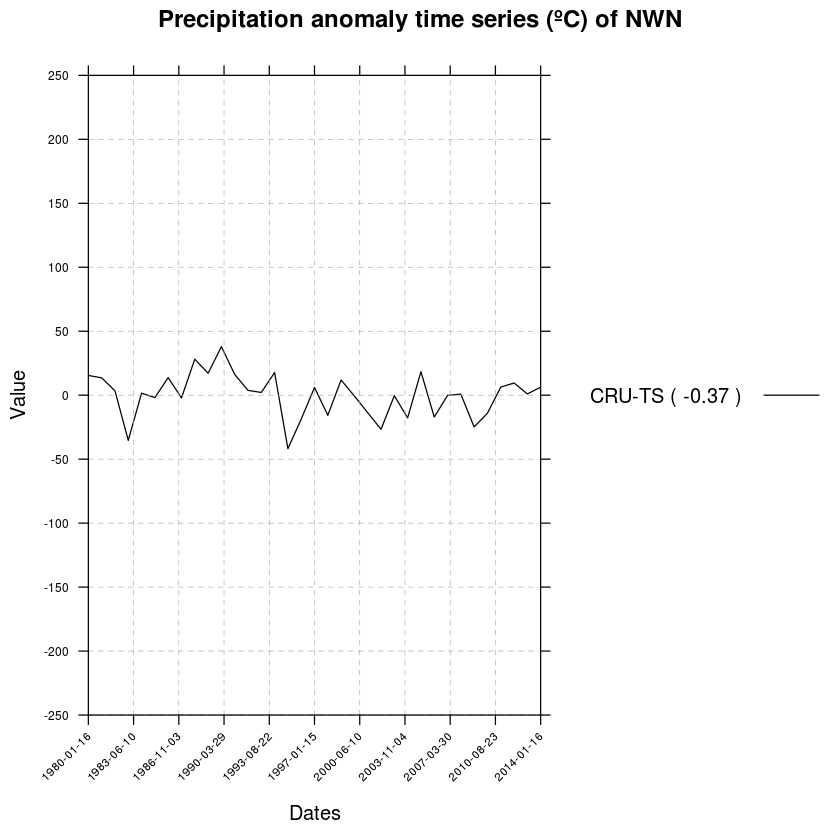

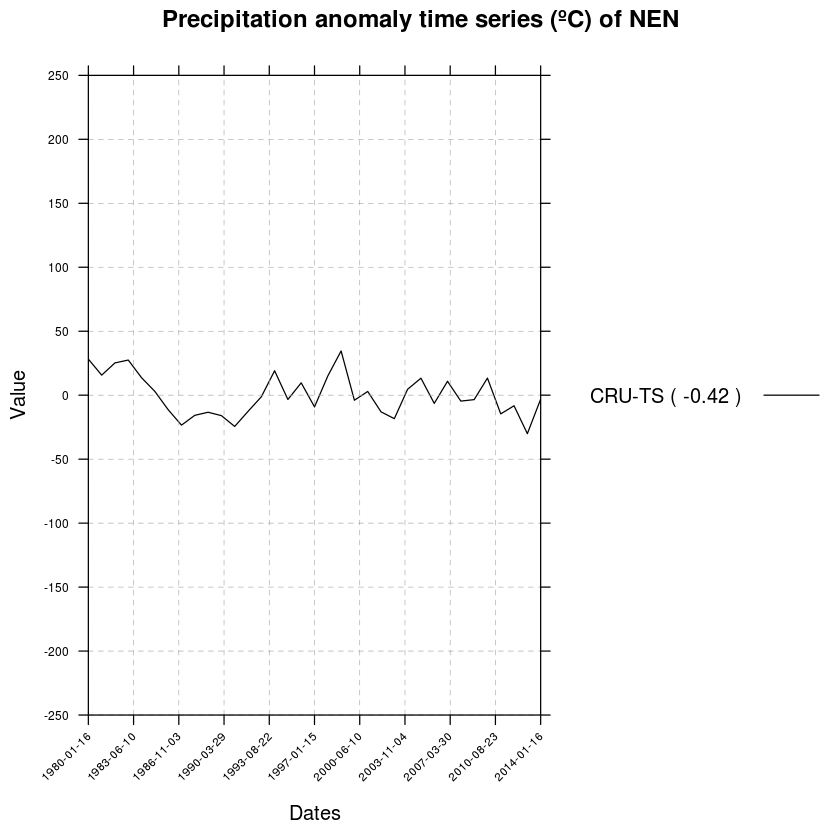

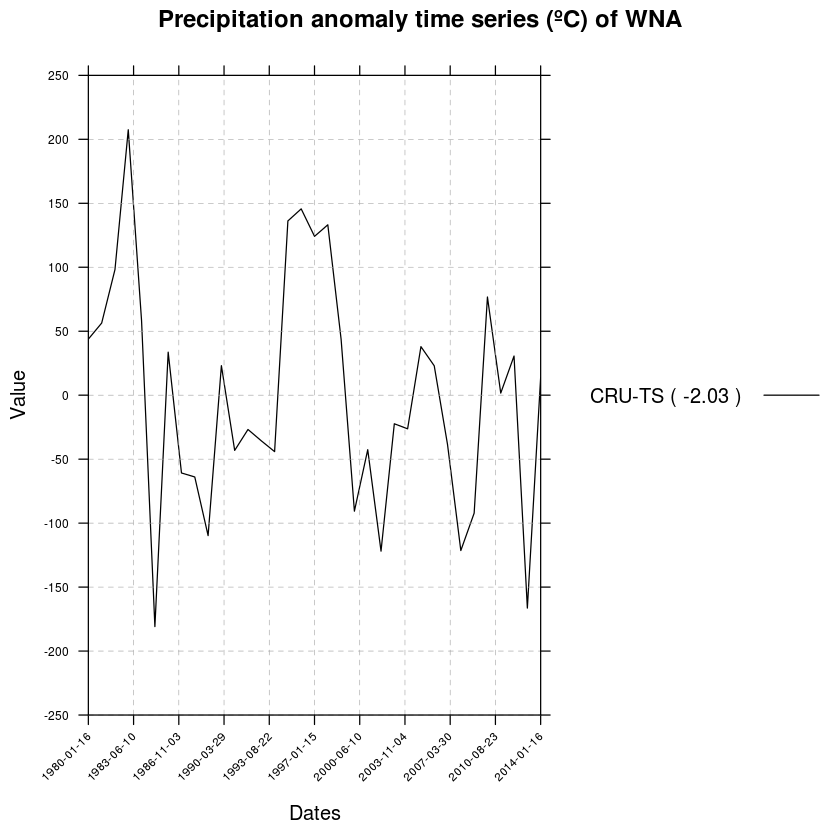

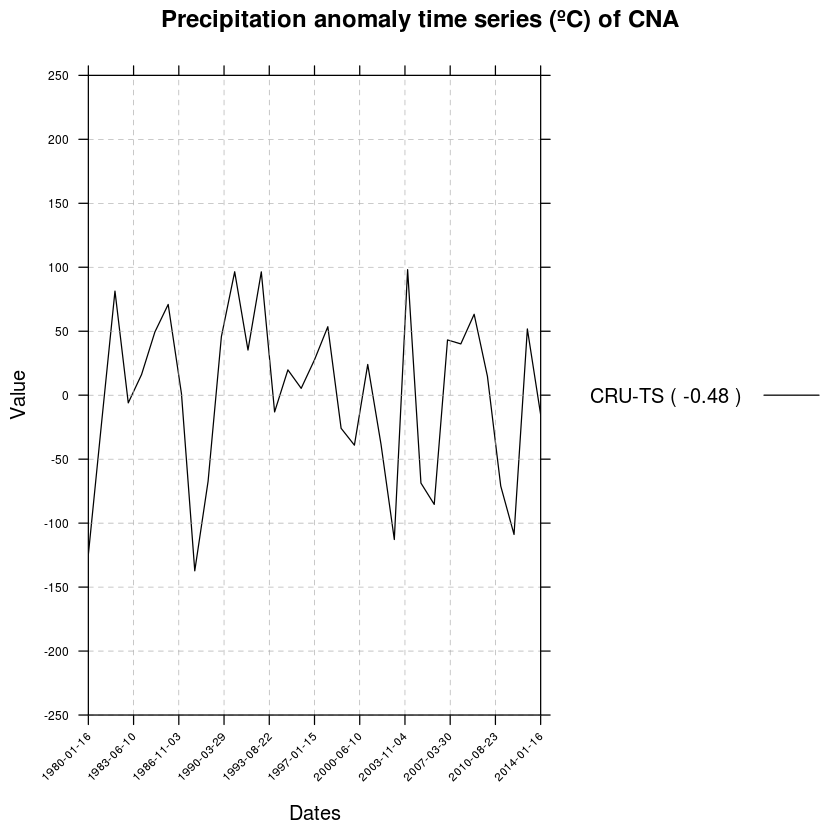

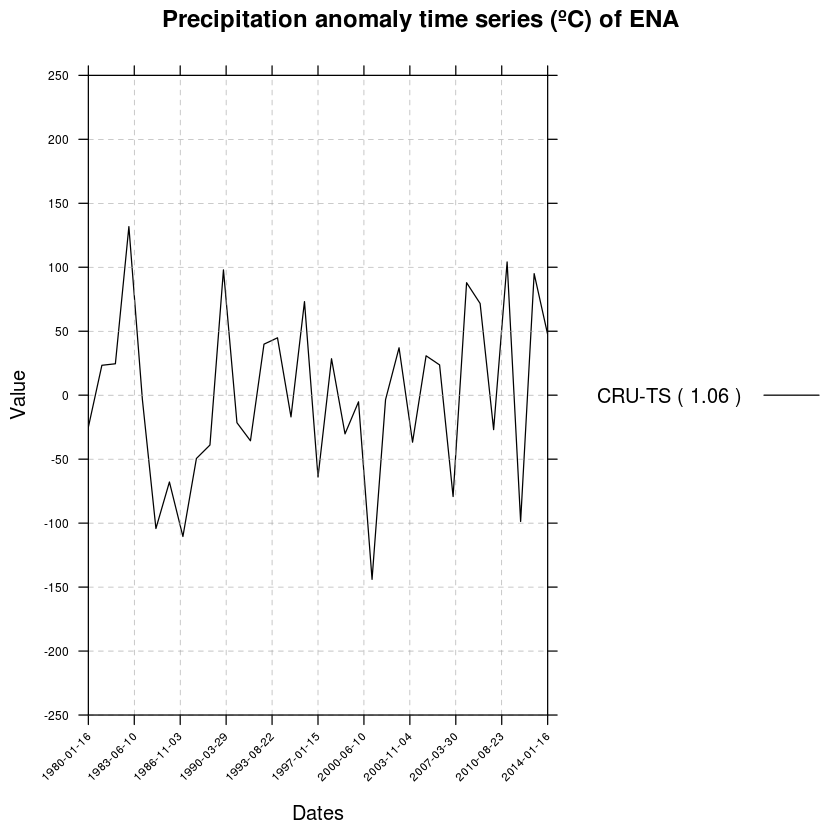

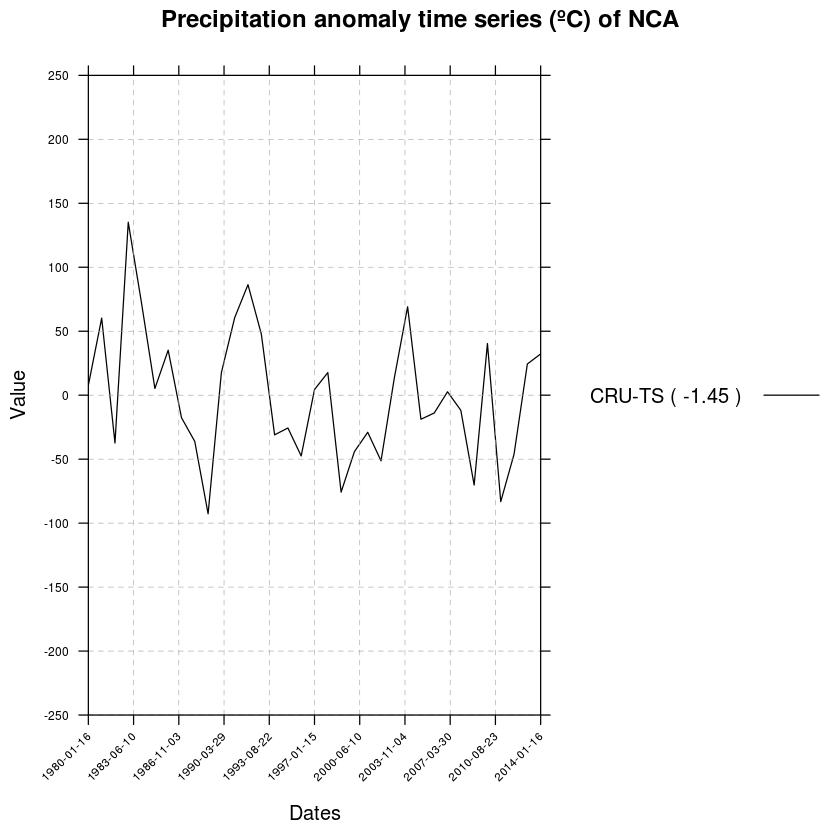

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]


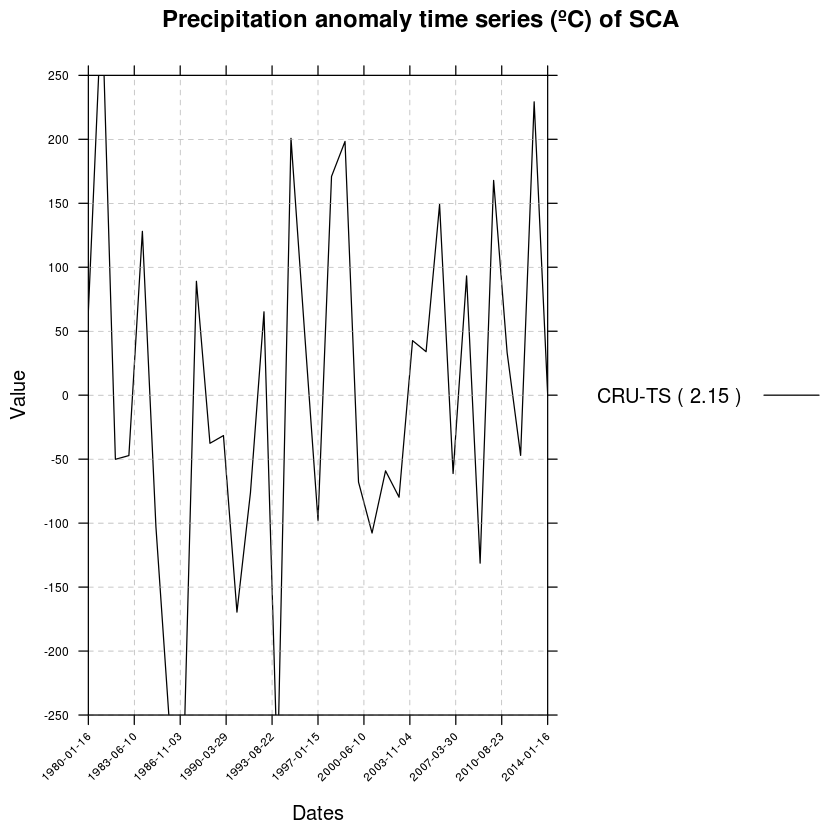

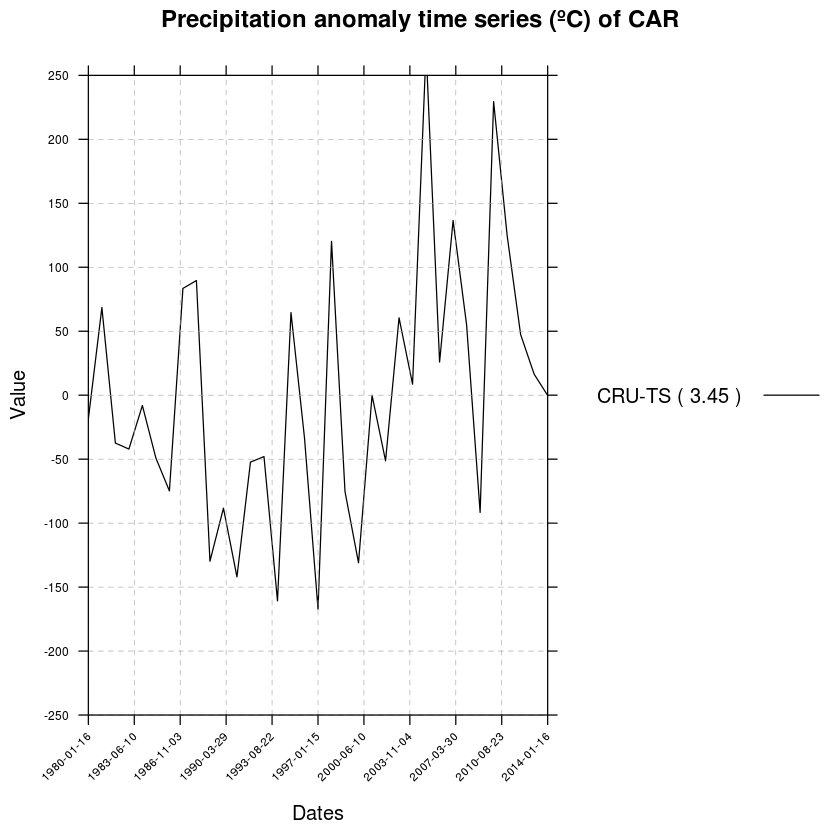

In [34]:
lapply(1:length(grid.anom), FUN = function(x) {
  aux <- (linearTrend(grid.anom[[x]], p = 0.9) %>% subsetGrid(var = "b"))$Data[1]
  
  key.trans <- list(space="right",
                    text=list(c(paste("CRU-TS","(",round(aux,digits=2),")"))),
                    lines=list(col=c("black"), lty = c(1)))                
  temporalPlot(grid.anom[[x]],
               xyplot.custom = list(
                 main = paste("Precipitation anomaly time series (ºC) of",regs.area[x]),
                 ylim = c(-250,250),
                 key = key.trans   
               ))
})                